Found 4415 images belonging to 10 classes.
Found 1337 images belonging to 10 classes.
Found 1362 images belonging to 10 classes.
Number of classes: 10
Training ResNet50...
Epoch 1/50
137/137 [==============================] - 117s 838ms/step - loss: 2.3662 - accuracy: 0.1314 - mAP: 0.5559 - val_loss: 2.2585 - val_accuracy: 0.1707 - val_mAP: 0.5964
Epoch 2/50
137/137 [==============================] - 114s 835ms/step - loss: 2.2955 - accuracy: 0.1462 - mAP: 0.5668 - val_loss: 2.2457 - val_accuracy: 0.1715 - val_mAP: 0.6096
Epoch 3/50
137/137 [==============================] - 119s 872ms/step - loss: 2.2692 - accuracy: 0.1656 - mAP: 0.5845 - val_loss: 2.2380 - val_accuracy: 0.1761 - val_mAP: 0.6093
Epoch 4/50
137/137 [==============================] - 121s 886ms/step - loss: 2.2557 - accuracy: 0.1647 - mAP: 0.5960 - val_loss: 2.2287 - val_accuracy: 0.1715 - val_mAP: 0.6173
Epoch 5/50
137/137 [==============================] - 121s 884ms/step - loss: 2.2598 - accuracy: 0.1579 - mAP: 0.593

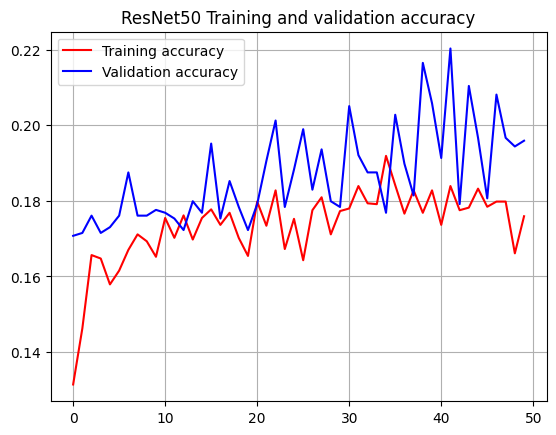

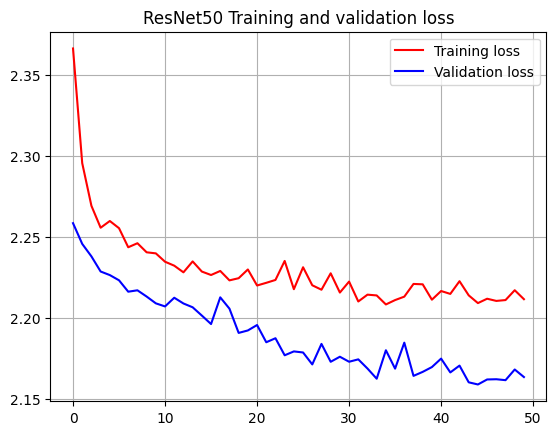

43/43 [==============================] - 30s 674ms/step


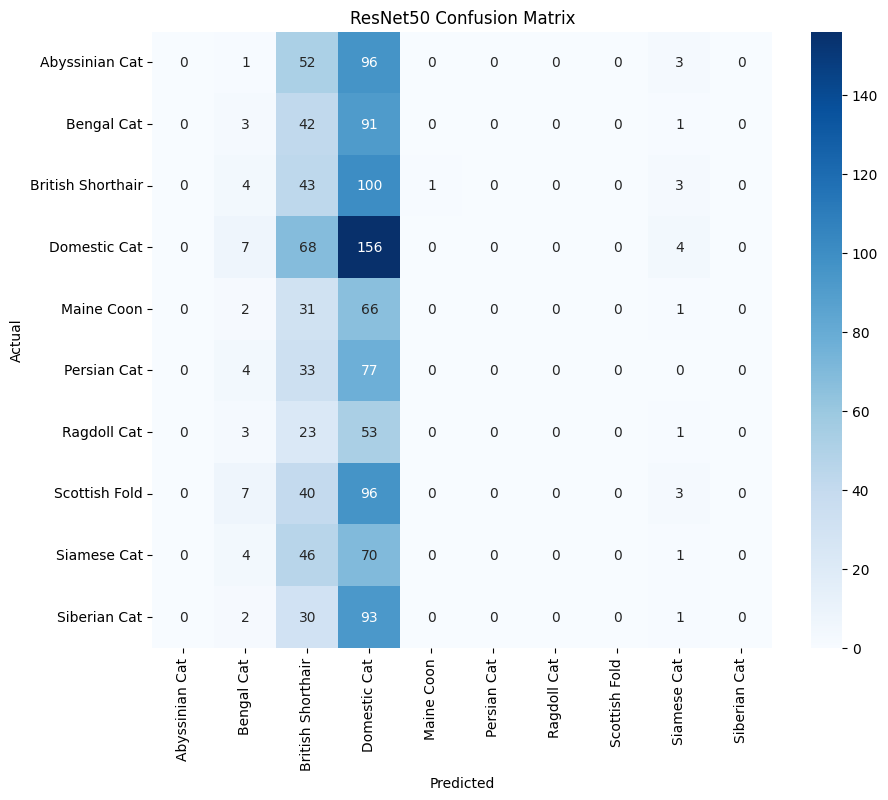

ResNet50 Classification Report:
                   precision    recall  f1-score   support

   Abyssinian Cat       0.00      0.00      0.00       152
       Bengal Cat       0.08      0.02      0.03       137
British Shorthair       0.11      0.28      0.15       151
     Domestic Cat       0.17      0.66      0.28       235
       Maine Coon       0.00      0.00      0.00       100
      Persian Cat       0.00      0.00      0.00       114
      Ragdoll Cat       0.00      0.00      0.00        80
    Scottish Fold       0.00      0.00      0.00       146
      Siamese Cat       0.06      0.01      0.01       121
     Siberian Cat       0.00      0.00      0.00       126

         accuracy                           0.15      1362
        macro avg       0.04      0.10      0.05      1362
     weighted avg       0.05      0.15      0.07      1362

Training times (in seconds): {'ResNet50': 6115.600079774857}
ResNet50 Best validation accuracy: 0.22027438879013062


C:\Users\dinih\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dinih\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dinih\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [1]:
# Ensure TensorFlow and necessary packages are installed
try:
    import tensorflow as tf
except ImportError:
    !pip install tensorflow
    import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, DenseNet121, MobileNetV3Small
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define data directories
train_data_dir = 'data/train'
val_data_dir = 'data/val'
test_data_dir = 'data/test'

# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Check the number of classes
num_classes = len(train_generator.class_indices)
print(f'Number of classes: {num_classes}')

def create_model(base_model):
    base_model.trainable = False  # Freeze the base model
    inputs = Input(shape=(150, 150, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)  # Added dropout layer for regularization
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

# Define the models
models_dict = {
    'ResNet50': create_model(ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3)))
}

# Compile the models
for model_name, model in models_dict.items():
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', AUC(name='mAP')])

# Train and evaluate the models
history_dict = {}
training_times = {}
for model_name, model in models_dict.items():
    print(f'Training {model_name}...')
    start_time = time.time()
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=50,
        validation_data=val_generator,
        validation_steps=val_generator.samples // val_generator.batch_size
    )
    end_time = time.time()
    training_times[model_name] = end_time - start_time
    history_dict[model_name] = history

    # Evaluate the model
    test_loss, test_acc, test_mAP = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'{model_name} Test accuracy: {test_acc}, Test mAP: {test_mAP}')

    # Save the model
    model.save(f'{model_name}_cat_classifier_model.h5')

    # Plot training and validation accuracy/loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure()
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title(f'{model_name} Training and validation accuracy')
    plt.legend()
    plt.grid()

    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'{model_name} Training and validation loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Confusion matrix
    y_pred = model.predict(test_generator)
    y_pred_class = np.argmax(y_pred, axis=1)
    y_true_class = test_generator.classes
    cm = confusion_matrix(y_true_class, y_pred_class)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Classification report
    print(f'{model_name} Classification Report:')
    print(classification_report(y_true_class, y_pred_class, target_names=list(test_generator.class_indices.keys())))

# Final conclusion
print("Training times (in seconds):", training_times)
for model_name, history in history_dict.items():
    print(f'{model_name} Best validation accuracy: {max(history.history["val_accuracy"])}')